In [1]:
import pandas as pd
import numpy as np
import wfdb
import glob
import re
from tqdm import tqdm
import joblib
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import warnings; warnings.filterwarnings('ignore')

In [2]:
SNOMED_CODES = {
    '426783006': 'NORM', 
    '164889003': 'AF',
    '270492004': 'IAVB',
    '164909002': 'LBBB',
    '59118001': 'RBBB',
    '284470004': 'PAC',
    '164884008': 'VEB', #
    '429622005': 'STD',
    '164931005': 'STE',
}

LABELS = ['NORM', 'AF', 'IAVB', 'LBBB', 'RBBB', 'PAC', 'VEB', 'STD', 'STE']

In [3]:
data_path = './data/origin/'

In [5]:
def downsample(signal, ratio=5):
    # Signal of size (L, 12) to (L/ratio, 12)
    return signal[::ratio, :]


In [6]:
LENGTH = 1000
def crop(signal):
    return signal[0:LENGTH, :]

In [9]:
def load_raw_data(path):
    headers = glob.glob(path+'*.hea')
    headers = [h[:-4] for h in headers] # remove extensions
    data = []
    labels = []
    scaler = MinMaxScaler((-1, 1))

    for f in tqdm(headers):
        signal, meta = wfdb.rdsamp(f)
        
        # Signal
        downsampled = downsample(signal)
        l = downsampled.shape[0]
        if l < LENGTH: # drop 6 signals of length < 1000
            continue
        elif l > LENGTH:
            downsampled = crop(downsampled)
            l = len(downsampled)
            assert l == LENGTH
            
        # Min-max scaling
        scaled = scaler.fit_transform(downsampled)
        
        data.append(scaled)
        
        # Label
        l = meta['comments'][2]
        assert l.startswith('Dx:') and l[3] == ' '
        lb = [0] * len(LABELS)
        # Set one-hot values for diagnosed labels
        for sc in l[4:].split(','):
            val = SNOMED_CODES[sc]
            idx = LABELS.index(val)
            lb[idx] = 1
            
        labels.append(lb)
        
    assert len(data) == len(labels)
    return np.array(data), np.array(labels)


In [10]:
X, y = load_raw_data(data_path)

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 6877/6877 [00:22<00:00, 301.52it/s]


### Split 

In [11]:
X.shape, y.shape

((6871, 1000, 12), (6871, 9))

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1, stratify=y)

In [13]:
y_train.sum(axis=0)/len(y_train)

array([0.13360852, 0.17749294, 0.10514882, 0.03432544, 0.27025853,
       0.08950684, 0.10145557, 0.12622203, 0.03193569])

In [14]:
y_test.sum(axis=0)/len(y_test)

array([0.13359788, 0.17768959, 0.10493827, 0.03395062, 0.27028219,
       0.08906526, 0.10229277, 0.12654321, 0.03218695])

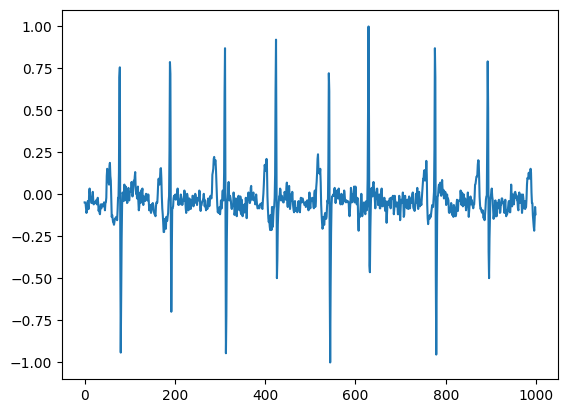

In [16]:
plt.plot(X_test[19, :, 5])

In [17]:
joblib.dump(X_train, './data/X_train.joblib')
joblib.dump(y_train, './data/y_train.joblib')
joblib.dump(X_test, './data/X_test.joblib')
joblib.dump(y_test, './data/y_test.joblib')

['./data/y_test.joblib']

In [18]:
X_train[0].shape

(1000, 12)

In [19]:
y_train[0].shape

(9,)

In [2]:
X_train = joblib.load('./data/X_train.joblib')
y_train = joblib.load('./data/y_train.joblib')
X_test = joblib.load('./data/X_test.joblib')
y_test = joblib.load('./data/y_test.joblib')



In [3]:
X_train.shape

(4603, 1000, 12)

In [4]:
X_full = np.concatenate((X_train, X_test))
X_full.shape

(6871, 1000, 12)

In [5]:
y_full = np.concatenate((y_train, y_test))
y_full.shape

(6871, 9)

In [6]:
joblib.dump(X_full, './data/X_full.joblib')
joblib.dump(y_full, './data/y_full.joblib')

['./data/y_full.joblib']